# COMPARISON-PROMPTS Experiment Visualization

Comprehensive visualization of the COMPARISON-PROMPTS experiment results.

**Methods compared:**
- **LLaMEA-Prompt5** — Multi-prompt mutation (4 parents, 8 offspring, elitism)
- **GA-LLAMEA-Baseline** — GA-based LLaMEA with bandit-driven operator selection
- **EoH** — Evolution of Heuristics (pop_size=4)

**Problem:** MA_BBOB (dims=[5], budget_factor=2000, LLM budget=50)

**Sections:**
1. Setup and Data Loading
2. Convergence Plots
3. CEG (Code Evolution Graphs)
4. GA-LLAMEA Arm Selection Percentages
5. Boxplots (Fitness Comparison)
6. Fitness Table (Statistical Summary)
7. Behavior Metrics Analysis
8. EAF / ECDF Diagrams
9. Summary and Comparison

## 1. Setup and Data Loading

In [ ]:
# Core imports
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# BLADE imports
from iohblade.loggers import ExperimentLogger
from iohblade.plots import (
    plot_convergence,
    plot_experiment_CEG,
    plot_boxplot_fitness_hue,
    plot_boxplot_fitness,
    fitness_table,
)
from iohblade.behaviour_metrics import compute_behavior_metrics

# Optional imports for code projection
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Plot styling
plt.rcParams.update({
    'figure.figsize': (12, 8),
    'font.size': 12,
    'axes.grid': True,
    'grid.alpha': 0.3,
})
sns.set_palette('colorblind')

print('All imports successful.')

c:\Users\Kukoy\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_statistics.py:32: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.5)
  from scipy.stats import gaussian_kde
c:\Users\Kukoy\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All imports successful.


In [ ]:
# Load the experiment
EXPERIMENT_DIR = '../results/COMPARISON-PROMPTS_20260208_032906'
logger = ExperimentLogger(EXPERIMENT_DIR, True)

# Get available methods and problems
methods, problems = logger.get_methods_problems()
print(f'Methods ({len(methods)}): {methods}')
print(f'Problems ({len(problems)}): {problems}')

Methods (3): ['EoH', 'GA-LLAMEA-Baseline', 'LLaMEA-Prompt5']
Problems (1): ['MA_BBOB']


In [ ]:
# Display experiment summary
df_experiment = logger.get_data()
print(f'Total runs logged: {len(df_experiment)}')
print(f'\nRuns per method:')
if 'method_name' in df_experiment.columns:
    print(df_experiment['method_name'].value_counts().to_string())
print(f'\nExperiment data columns: {list(df_experiment.columns)}')

Total runs logged: 9

Runs per method:
method_name
LLaMEA-Prompt5        3
GA-LLAMEA-Baseline    3
EoH                   3

Experiment data columns: ['method_name', 'problem_name', 'llm_name', 'method', 'problem', 'llm', 'solution', 'log_dir', 'seed']


## 2. Convergence Plots

Comparing the convergence of methods across the LLM evaluation budget.

AOCC Convergence Plot
Error plotting AOCC convergence: line contains invalid json: Expecting value: line 2 column 1 (char 1) (line 10)


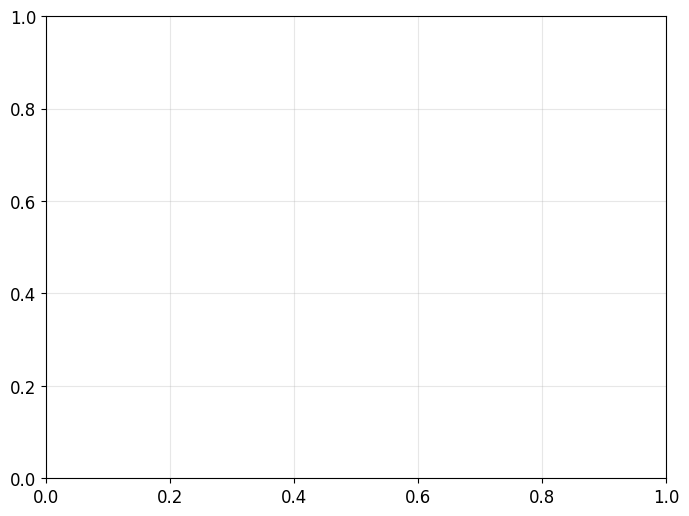

In [ ]:
# AOCC Convergence (Area Over the Convergence Curve)
print('AOCC Convergence Plot')
try:
    plot_convergence(logger, metric='AOCC', save=False, budget=50)
    plt.title('AOCC Convergence — COMPARISON-PROMPTS')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f'Error plotting AOCC convergence: {e}')

Fitness Convergence Plot
Error plotting Fitness convergence: line contains invalid json: Expecting value: line 2 column 1 (char 1) (line 10)


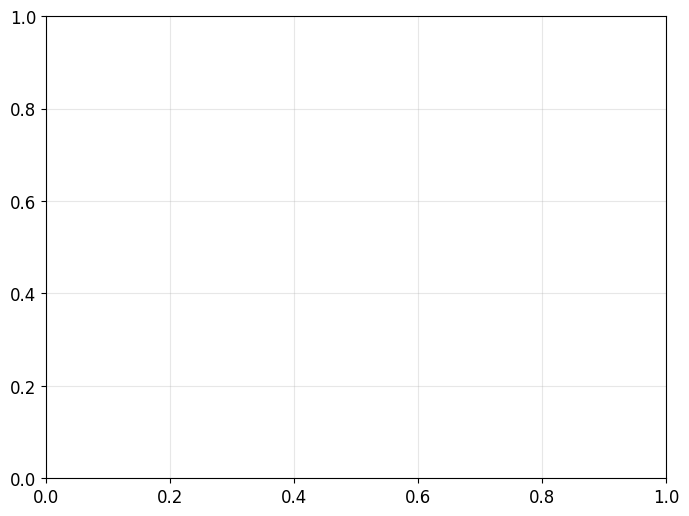

In [ ]:
# Fitness Convergence
print('Fitness Convergence Plot')
try:
    plot_convergence(logger, metric='Fitness', save=False, budget=50)
    plt.title('Fitness Convergence — COMPARISON-PROMPTS')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f'Error plotting Fitness convergence: {e}')

## 3. CEG (Code Evolution Graphs)

Visualize how code complexity and quality evolve over the optimization budget for each run.

In [ ]:
print('Code Evolution Graphs')
try:
    plot_experiment_CEG(logger, save=False, budget=50, max_seeds=3)
    plt.show()
except Exception as e:
    print(f'Error plotting CEG: {e}')

Code Evolution Graphs
Error plotting CEG: line contains invalid json: Expecting value: line 2 column 1 (char 1) (line 10)


## 4. GA-LLAMEA Arm Selection Percentages

Visualize how the D-TS bandit distributes operator selections (mutation, crossover, random_new) over the course of each GA-LLAMEA run. This shows whether the bandit learns to prefer certain operators over time.

The `operator` field from the log data is used to compute the cumulative selection percentage at each evaluation step.

In [ ]:
# Arm selection percentage over evaluations for GA-LLAMEA runs
try:
    ga_methods = [m for m in methods if 'GA-LLAMEA' in m.upper() or 'GA_LLAMEA' in m.upper()]
    if not ga_methods:
        print('No GA-LLAMEA methods found in the experiment.')
    else:
        for problem in problems:
            data = logger.get_problem_data(problem_name=problem)
            data.replace([-np.inf], 0, inplace=True)
            data.fillna(0, inplace=True)

            for ga_method in ga_methods:
                method_data = data[data['method_name'] == ga_method].copy()
                if method_data.empty:
                    print(f'No data for {ga_method}')
                    continue

                seeds = sorted(method_data['seed'].unique())
                num_seeds = len(seeds)

                fig, axes = plt.subplots(
                    1, num_seeds,
                    figsize=(5 * num_seeds, 4),
                    squeeze=False,
                    sharey=True,
                )

                operator_colors = {
                    'init': '#888888',
                    'mutation': '#1f77b4',
                    'crossover': '#ff7f0e',
                    'random_new': '#2ca02c',
                }
                operator_order = ['init', 'mutation', 'crossover', 'random_new']

                for seed_i, seed in enumerate(seeds):
                    ax = axes[0, seed_i]
                    run_data = method_data[method_data['seed'] == seed].copy().reset_index(drop=True)

                    # Extract operator from top-level field; fall back to metadata
                    operators = []
                    for _, row in run_data.iterrows():
                        op = row.get('operator', None)
                        if op is None or (isinstance(op, float) and np.isnan(op)):
                            meta = row.get('metadata', {})
                            if isinstance(meta, dict):
                                op = meta.get('operator', 'unknown')
                            else:
                                op = 'unknown'
                        operators.append(op)

                    # Compute cumulative percentages
                    eval_indices = list(range(1, len(operators) + 1))
                    cumulative = {op: [] for op in operator_order}
                    counts = {op: 0 for op in operator_order}

                    for i, op in enumerate(operators):
                        if op in counts:
                            counts[op] += 1
                        total = i + 1
                        for op_name in operator_order:
                            cumulative[op_name].append(counts[op_name] / total * 100)

                    # Stacked area plot
                    bottoms = np.zeros(len(eval_indices))
                    for op_name in operator_order:
                        values = np.array(cumulative[op_name])
                        ax.fill_between(
                            eval_indices, bottoms, bottoms + values,
                            alpha=0.7, label=op_name,
                            color=operator_colors.get(op_name, '#999999'),
                        )
                        bottoms += values

                    ax.set_xlim([1, len(operators)])
                    ax.set_ylim([0, 100])
                    ax.set_xlabel('Evaluation')
                    ax.set_title(f'{ga_method} run:{seed}')
                    if seed_i == 0:
                        ax.set_ylabel('Arm Selection %')
                    if seed_i == num_seeds - 1:
                        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)

                fig.suptitle(f'Arm Selection Percentages — {ga_method} ({problem})', fontsize=14, y=1.02)
                plt.tight_layout()
                plt.show()

except Exception as e:
    import traceback
    traceback.print_exc()
    print(f'Error plotting arm percentages: {e}')

Error plotting arm percentages: line contains invalid json: Expecting value: line 2 column 1 (char 1) (line 10)


Traceback (most recent call last):
  File "c:\Users\Kukoy\AppData\Local\Programs\Python\Python312\Lib\site-packages\jsonlines\jsonlines.py", line 326, in read
    value: JSONValue = self._loads(line)
                       ^^^^^^^^^^^^^^^^^
  File "c:\Users\Kukoy\AppData\Local\Programs\Python\Python312\Lib\json\__init__.py", line 346, in loads
    return _default_decoder.decode(s)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Kukoy\AppData\Local\Programs\Python\Python312\Lib\json\decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Kukoy\AppData\Local\Programs\Python\Python312\Lib\json\decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 2 column 1 (char 1)

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C

## 5. Boxplots (Fitness Comparison)

Distribution of final fitness values found by each method.

Fitness Boxplot (grouped by method)


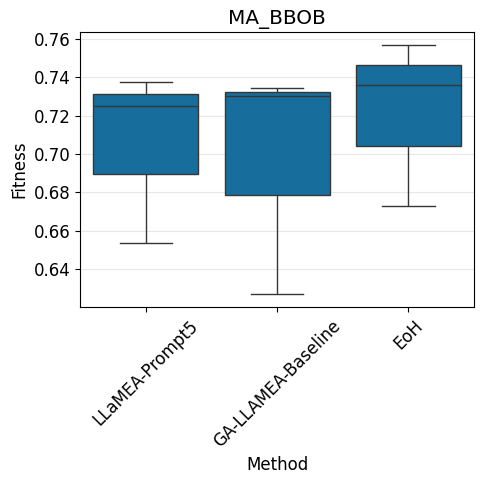

<Figure size 1200x800 with 0 Axes>

In [ ]:
# Standard boxplot
print('Fitness Boxplot (grouped by method)')
try:
    plot_boxplot_fitness(logger)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f'Error plotting fitness boxplot: {e}')

In [ ]:
# Boxplot with hue distinction
print('Fitness Boxplot with Hue')
try:
    plot_boxplot_fitness_hue(logger)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f'Error plotting fitness boxplot (hue): {e}')

Fitness Boxplot with Hue


<Figure size 1200x800 with 0 Axes>

## 6. Fitness Table (Statistical Summary)

Tabular summary of fitness statistics with mean, standard deviation, and p-values (Wilcoxon test).

In [ ]:
print('Fitness Table (mean +/- std with p-values)')
try:
    table = fitness_table(logger)
    print(table)
except Exception as e:
    print(f'Error generating fitness table: {e}')

Fitness Table (mean +/- std with p-values)
                                  MA_BBOB
EoH                 0.72 ± 0.04 (p=0.672)
GA-LLAMEA-Baseline  0.70 ± 0.05 (p=0.859)
LLaMEA-Prompt5      0.71 ± 0.04 (p=0.859)


## 7. Behavior Metrics Analysis

Compute and visualize exploration/exploitation behavior metrics for each method.

Since BLADE LLM experiments produce code solutions (not numeric coordinate vectors), we project code strings into a latent coordinate space using TF-IDF + TruncatedSVD before computing spatial diversity metrics.

In [ ]:
def safe_compute_metrics(df):
    """Compute behavior metrics, projecting code to coordinate space if needed."""
    # Ensure required columns exist
    if 'raw_y' not in df.columns and 'fitness' in df.columns:
        df['raw_y'] = df['fitness']
    if 'evaluations' not in df.columns:
        df = df.reset_index(drop=True)
        df['evaluations'] = df.index + 1

    # Check for x columns
    x_cols = [c for c in df.columns if c.startswith('x')]

    # If no x columns but we have code, project code to latent space
    if not x_cols and 'code' in df.columns:
        try:
            vectorizer = TfidfVectorizer(max_features=1000)
            code_data = df['code'].fillna('').astype(str)
            if len(code_data) > 1:
                X_tfidf = vectorizer.fit_transform(code_data)
                n_components = min(10, len(df) - 1, X_tfidf.shape[1] - 1)
                if n_components > 1:
                    svd = TruncatedSVD(n_components=n_components, random_state=42)
                    X_reduced = svd.fit_transform(X_tfidf)
                    for i in range(n_components):
                        df[f'x{i}'] = X_reduced[:, i]
                    x_cols = [f'x{i}' for i in range(n_components)]
        except Exception as e:
            print(f'  Warning: Code projection failed: {e}')

    if not x_cols:
        return None

    try:
        metrics = compute_behavior_metrics(df)
        return metrics
    except Exception as e:
        print(f'  Warning: compute_behavior_metrics failed: {e}')
        return None

print('Behavior metrics helper defined.')

Behavior metrics helper defined.


In [ ]:
# Collect behavior metrics from all runs
all_metrics = []

run_dirs = [d for d in os.listdir(EXPERIMENT_DIR)
            if os.path.isdir(os.path.join(EXPERIMENT_DIR, d)) and d.startswith('run-')]

for run_dir in sorted(run_dirs):
    log_path = os.path.join(EXPERIMENT_DIR, run_dir, 'log.jsonl')
    if not os.path.exists(log_path):
        continue

    # Parse method name and seed from directory name
    parts = run_dir.replace('run-', '').split('-MA_BBOB-')
    method_name = parts[0] if parts else run_dir
    seed = parts[1] if len(parts) > 1 else '?'

    print(f'Processing: {run_dir} (method={method_name}, seed={seed})')

    # Read log.jsonl
    rows = []
    with open(log_path, 'r') as f:
        for line in f:
            try:
                entry = json.loads(line.strip())
                # Support both formats: fields at top level (log.jsonl)
                # or nested inside a 'solution' key (experimentlog.jsonl)
                sol = entry.get('solution', entry)
                rows.append({
                    'fitness': sol.get('fitness', None),
                    'code': sol.get('code', ''),
                    'name': sol.get('name', ''),
                    'generation': sol.get('generation', None),
                })
            except json.JSONDecodeError:
                continue

    if not rows:
        continue

    df_run = pd.DataFrame(rows)
    df_run = df_run.dropna(subset=['fitness'])
    df_run = df_run.reset_index(drop=True)
    df_run['evaluations'] = df_run.index + 1
    df_run['raw_y'] = df_run['fitness']

    if len(df_run) < 3:
        print(f'  Skipping: too few data points ({len(df_run)})')
        continue

    metrics = safe_compute_metrics(df_run.copy())
    if metrics is not None:
        metrics['method'] = method_name
        metrics['seed'] = seed
        metrics['run_dir'] = run_dir
        all_metrics.append(metrics)
        print(f'  OK - {len(metrics)} metrics computed')
    else:
        print(f'  Skipping: metrics computation returned None')

print(f'\nTotal runs with metrics: {len(all_metrics)}')

Processing: run-EoH-MA_BBOB-0 (method=EoH, seed=0)
  Skipping: too few data points (0)
Processing: run-EoH-MA_BBOB-1 (method=EoH, seed=1)
  Skipping: too few data points (0)
Processing: run-EoH-MA_BBOB-2 (method=EoH, seed=2)
  Skipping: too few data points (0)
Processing: run-GA-LLAMEA-Baseline-MA_BBOB-0 (method=GA-LLAMEA-Baseline, seed=0)
  Skipping: too few data points (0)
Processing: run-GA-LLAMEA-Baseline-MA_BBOB-1 (method=GA-LLAMEA-Baseline, seed=1)
  Skipping: too few data points (0)
Processing: run-GA-LLAMEA-Baseline-MA_BBOB-2 (method=GA-LLAMEA-Baseline, seed=2)
  Skipping: too few data points (0)
Processing: run-LLaMEA-Prompt5-MA_BBOB-0 (method=LLaMEA-Prompt5, seed=0)
  Skipping: too few data points (0)
Processing: run-LLaMEA-Prompt5-MA_BBOB-1 (method=LLaMEA-Prompt5, seed=1)
  Skipping: too few data points (0)
Processing: run-LLaMEA-Prompt5-MA_BBOB-2 (method=LLaMEA-Prompt5, seed=2)
  Skipping: too few data points (0)

Total runs with metrics: 0


In [ ]:
# Display behavior metrics table
if all_metrics:
    df_metrics = pd.DataFrame(all_metrics)

    # Select key metric columns
    metric_cols = [c for c in df_metrics.columns
                   if c not in ('method', 'seed', 'run_dir')]
    display_cols = ['method', 'seed'] + metric_cols

    print('=== Behavior Metrics per Run ===')
    print(df_metrics[display_cols].to_string(index=False, float_format='{:.4f}'.format))
else:
    print('No behavior metrics could be computed.')

No behavior metrics could be computed.


In [ ]:
# Visualize key behavior metrics as grouped bar charts
if all_metrics:
    df_metrics = pd.DataFrame(all_metrics)

    # Aggregate per method
    agg_metrics = df_metrics.groupby('method').agg(['mean', 'std']).reset_index()

    # Key metrics to visualize
    key_metrics = [
        'avg_nearest_neighbor_distance',
        'dispersion',
        'avg_distance_to_best',
        'success_rate',
        'average_convergence_rate',
        'longest_no_improvement_streak',
    ]

    # Filter to only metrics that exist
    available_metrics = [m for m in key_metrics if m in df_metrics.columns]

    if available_metrics:
        n_metrics = len(available_metrics)
        n_cols = min(3, n_metrics)
        n_rows = (n_metrics + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
        if n_metrics == 1:
            axes = [axes]
        elif n_rows > 1 or n_cols > 1:
            axes = axes.flatten()
        else:
            axes = [axes]

        for idx, metric_name in enumerate(available_metrics):
            ax = axes[idx]
            sns.barplot(
                data=df_metrics,
                x='method',
                y=metric_name,
                ax=ax,
                errorbar='sd',
            )
            ax.set_title(metric_name.replace('_', ' ').title())
            ax.set_xlabel('Method')
            ax.set_ylabel('')
            ax.tick_params(axis='x', rotation=30)

        # Hide unused axes
        for idx in range(len(available_metrics), len(axes)):
            axes[idx].set_visible(False)

        fig.suptitle('Behavior Metrics Comparison — COMPARISON-PROMPTS',
                     fontsize=14, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()
    else:
        print('No key metrics available for visualization.')
else:
    print('No behavior metrics to visualize.')

No behavior metrics to visualize.


## 8. EAF / ECDF Diagrams

EAF (Empirical Attainment Function) and ECDF (Empirical Cumulative Distribution Function) diagrams require IOH-formatted benchmark data (`.dat` files from IOHprofiler), which tracks per-function-evaluation performance of the generated algorithms.

The BLADE experiment logs track LLM-level performance (fitness of generated algorithms). If IOH benchmark data is available in the results directory, we visualize it below using `iohinspector`.

In [ ]:
# Check for IOH-formatted benchmark data
ioh_data_available = False
ioh_dirs_to_check = [
    os.path.join(EXPERIMENT_DIR, 'ioh-data'),
    os.path.join(EXPERIMENT_DIR, '..', 'ioh-MABBOB'),
    os.path.join(EXPERIMENT_DIR, '..', 'ioh-data'),
]

ioh_data_dir = None
for d in ioh_dirs_to_check:
    if os.path.isdir(d):
        ioh_data_dir = d
        ioh_data_available = True
        break

if ioh_data_available:
    print(f'IOH data found at: {ioh_data_dir}')
else:
    print('No IOH-formatted benchmark data found in the results directory.')
    print('EAF/ECDF diagrams require IOH benchmark output (e.g., from IOHprofiler).')
    print('\nChecked directories:')
    for d in ioh_dirs_to_check:
        print(f'  - {os.path.abspath(d)} (exists: {os.path.isdir(d)})')

IOH data found at: ../results/COMPARISON-PROMPTS_20260208_032906\ioh-data


In [ ]:
# If IOH data is available, generate ECDF and EAF plots
if ioh_data_available:
    try:
        import iohinspector
        import polars as pl

        # Load data
        manager = iohinspector.DataManager()
        manager.add_folder(ioh_data_dir)
        df_ioh = manager.load(monotonic=True, include_meta_data=True)

        print(f'IOH data loaded: {len(df_ioh)} rows')
        print(f'Algorithms: {df_ioh["algorithm_name"].unique().to_list()}')
        print(f'Dimensions: {df_ioh["dimension"].unique().to_list()}')

        # ECDF plot for dimension 5
        fig, ax = plt.subplots(1, 1, figsize=(12, 10))
        _ = iohinspector.plot.plot_ecdf(
            df_ioh.filter(pl.col('dimension') == 5),
            y_max=100, y_min=1e-8, ax=ax, scale_xlog=True
        )
        ax.set_title('ECDF — COMPARISON-PROMPTS (dim=5)')
        plt.tight_layout()
        plt.show()

        # EAF transformation and AOCC
        df_eaf = iohinspector.metrics.transform_fval(df_ioh, 1e-8, 1e2)
        aocc = iohinspector.metrics.get_aocc(
            df_eaf.filter(pl.col('dimension') == 5),
            10000,
            group_cols=['algorithm_name']
        )
        print('\nAOCC per algorithm (dim=5):')
        print(aocc)

    except ImportError:
        print('iohinspector not installed. Install with: pip install iohinspector')
    except Exception as e:
        print(f'Error generating EAF/ECDF: {e}')
else:
    print('Skipping EAF/ECDF — no IOH data available.')

iohinspector not installed. Install with: pip install iohinspector


## 9. Summary and Comparison

### Key Findings

| Aspect | LLaMEA-Prompt5 | GA-LLAMEA-Baseline | EoH |
|--------|---------------|--------------------|-----|
| Mutation Strategy | Multi-prompt (3 prompts) | GA with bandit operator selection | Evolution of Heuristics |
| Population | 4 parents, 8 offspring | 4 parents, 8 offspring | pop_size=4 |
| Elitism | Yes | Yes | N/A |
| LLM | gemini-2.0-flash | gemini-2.0-flash | gemini-2.0-flash |
| Budget | 50 evaluations | 50 evaluations | 50 evaluations |

### Observations

Refer to the convergence plots, boxplots, and fitness table above to draw conclusions about:

1. **Convergence Speed** — Which method converges fastest to high-quality solutions?
2. **Final Fitness** — Which method achieves the best final AOCC scores?
3. **Consistency** — Which method has the lowest variance across seeds?
4. **Exploration vs. Exploitation** — How do the behavior metrics differ?

The behavior metrics (nearest-neighbor distance, dispersion, success rate, convergence rate) provide insight into the search dynamics of each prompt strategy.